# Data streaming

## Task 3. Flow data discretization task

Group 97

We aim to learn a sequential model from NetFlow data from an infected host (unidirectional netflows). Consider scenario 10 from the CTU-13 dataset. Remove all background flows from the data. You are to discretize the NetFlows. Investigate the data from one of the infected hosts. Select and visualize two features that you believe are most relevant for modeling the behavior of the infected host. Discretize these featues using any of the methods discussed in class (combine the two values into a single discrete value). Do you observe any behavior in the two features that could be useful for detecting the infection? Explain. Apply the discretization to data from all hosts in the selected scenario.

Reference: "An empirical comparison of botnet detection methods" Sebastian Garcia, Martin Grill, Jan Stiborek and Alejandro Zunino. Computers and Security Journal, Elsevier. 2014. Vol 45, pp 100-123. http://dx.doi.org/10.1016/j.cose.2014.05.011

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

np.random.seed(42)
random.seed(42)
%matplotlib inline

In [2]:
# define filepath for scenario 10 dataset
filepath = './data/capture20110818.pcap.netflow.labeled'

# read data from the file
f = open(filepath, 'r')
lines = f.readlines()
f.close()
data = lines[1:] # drop the header

In [3]:
def preprocessing_remove_Background(data):
    '''data preprocessing
    Input
    -----
    string of a data flow
    
    Return
    ------
    None, if Background flow (to be removed)
    else cleaned, formated data
    '''
    if not 'Background' in data:
        s = data.split('\t')
        s = [x for x in s if x] # remove empty elements
        if len(s) < 12: # special fix for an outlier string @2011-08-18 12:18:31.264
            s = s[0].rsplit(' ', 11) 
        o = np.array([datetime.strptime(s[0], '%Y-%m-%d %H:%M:%S.%f').timestamp(), #time
                      float(s[1]), # duration
                      s[2], # protocol
                      s[3].split(':')[0], # ScrAddr
                      s[5].split(':')[0], # DstAddr
                      s[6].lstrip('_').rstrip('_').rstrip(), # flags
                      int(s[7]), # Tos
                      int(s[8]), # packets
                      int(s[9]), # bytes
                      int(s[10]), # flows
                      s[11].rstrip('\n').rstrip() # label
                     ])
    else:
        o = None
    return o

In [4]:
df = list(map(preprocessing_remove_Background, data)) # data preprocessing
df = [x for x in df if isinstance(x, np.ndarray)] # remove background flows
df = pd.DataFrame(df, columns=['Time', 'Duration', 'Protocol', 'ScrAddr', 'DstAddr', 
                               'Flags', 'Tos', 'Packets', 'Bytes', 'Flows', 'Label'])

# fix dtype again due to removal of background flows
df.Time = df.Time.astype(float)
df.Duration = df.Duration.astype(float)
df.Packets = df.Packets.astype(int)
df.Bytes = df.Bytes.astype(int)

## Visualisation

- Infected hosts
    - 147.32.84.165
    - 147.32.84.191
    - 147.32.84.192
    - 147.32.84.193
    - 147.32.84.204
    - 147.32.84.205
    - 147.32.84.206
    - 147.32.84.207
    - 147.32.84.208
    - 147.32.84.209

In [12]:
from sklearn.preprocessing import LabelEncoder

# make a dataframe for visualising the relations between variables
df_vis = df.copy()
df_vis.Protocol = LabelEncoder().fit_transform(df.Protocol)
df_vis.ScrAddr = LabelEncoder().fit_transform(df.ScrAddr)
df_vis.DstAddr = LabelEncoder().fit_transform(df.DstAddr)
df_vis.Flags = LabelEncoder().fit_transform(df.Flags)

# drop the variables that are not of interest (e.g. Time) or have one unique value (Tos=0, Flows=1)
df_vis.drop(columns=['Time', 'Tos', 'Flows'], inplace=True)

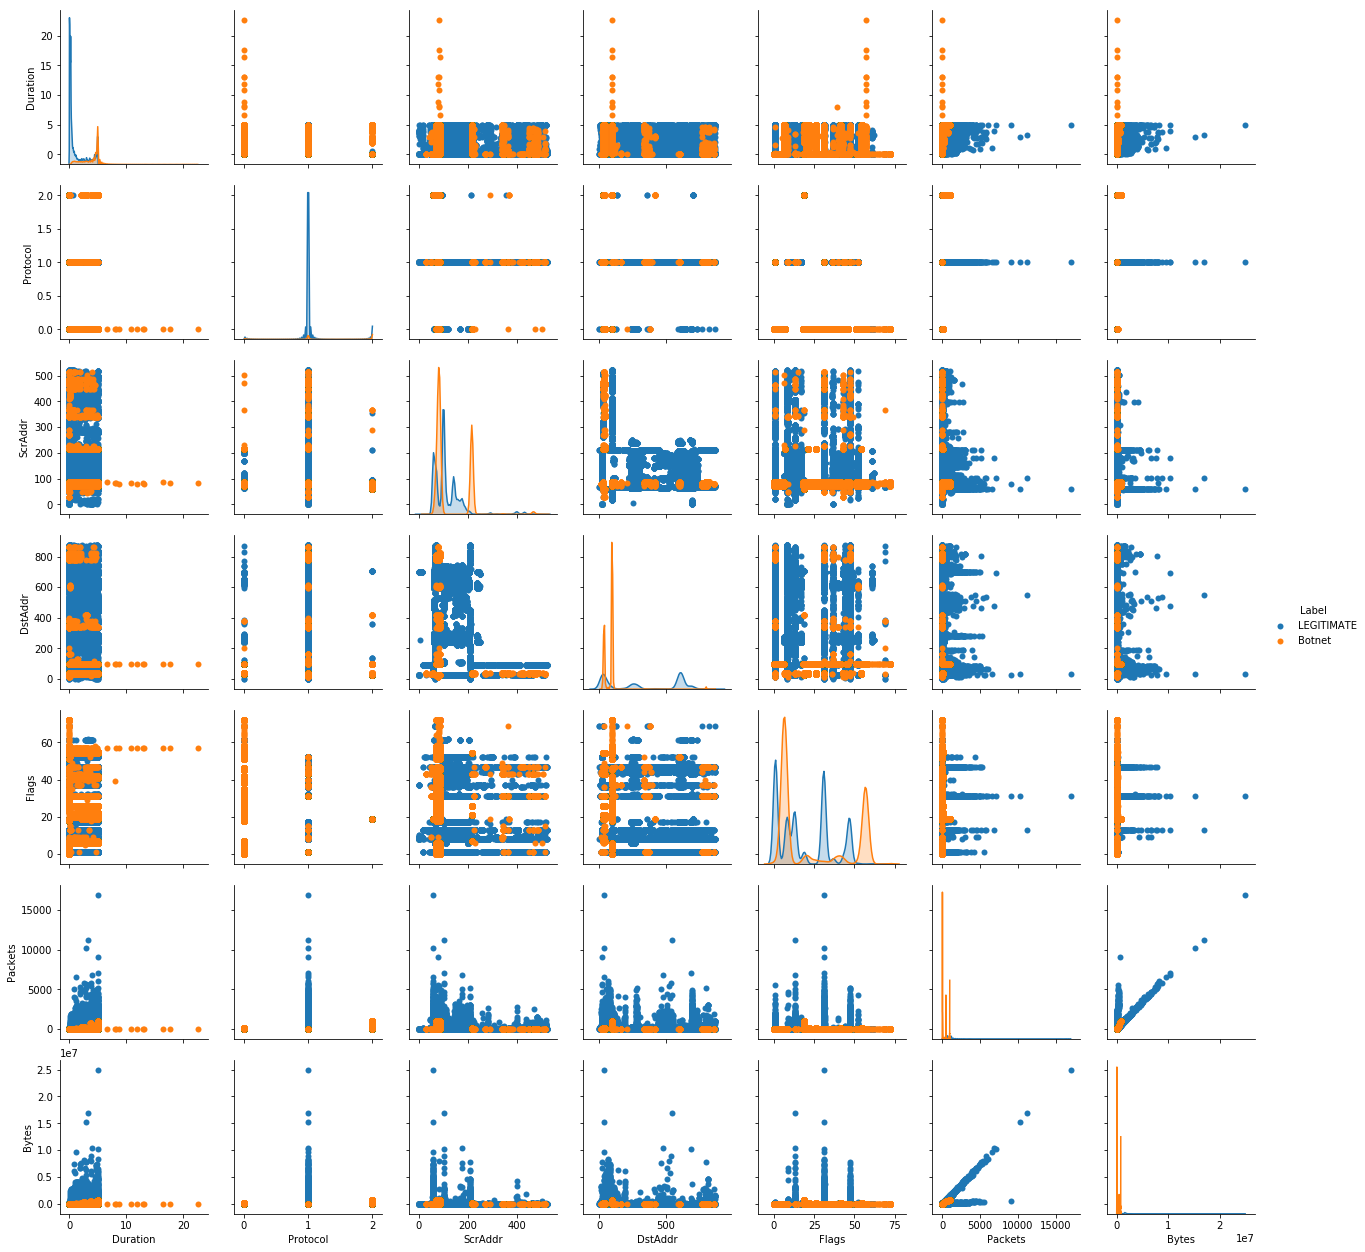

In [14]:
sns.pairplot(df_vis, hue='Label',
             diag_kind='kde', plot_kws={'linewidth': 0})